In [1]:
# Fill in your name using the given format
your_name = "Beeren, Nimo"

# Assignment 1
We will study SVMs on the [Fashion-MNIST dataset](https://www.openml.org/d/40996).
As we saw in the first lab session, it contains 70,000 images of fashion products, classified into 10 
types of clothing, each represented by 28 by 28 pixel values. 

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import openml
import time
import math
import tqdm
%matplotlib inline

# Pre-flight checklist. Do not change this code.
# Make sure that you have installed recent versions of key packages.
from packaging import version
import sklearn
sklearn_version = sklearn.__version__
if version.parse(sklearn_version) < version.parse("0.24.0"):
    print("scikit-learn is outdated. Please update now! pip install -U scikit-learn")
else:
    print("OK. You may continue :)")

ModuleNotFoundError: No module named 'pandas'

In [2]:
# Download FMINST data. Takes a while the first time.
# Note: these variables are the only ones that are assumed known. Define all other variables inside functions.
fmnist = openml.datasets.get_dataset(40996)
X, y, _, _ = fmnist.get_data(target=fmnist.default_target_attribute); 
fmnist_classes = {0:"T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 5: "Sandal", 
                  6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}

In [3]:
# Plotting functions. Don't edit these.
%matplotlib inline
from IPython import display

def plot_live(X, y, evaluator, param_name, param_range, scale='log', ylim=(0,1), ylabel='score', marker = '.'):
    """ Renders a plot that updates with every evaluation from the evaluator.
    Keyword arguments:
    X -- the data for training and testing
    y -- the correct labels
    evaluator -- a function with signature (X, y, param_value) that returns a dictionary of scores.
                 Examples: {"train": 0.9, "test": 0.95} or {"model_1": 0.9, "model_2": 0.7}
    param_name -- the parameter that is being varied on the X axis. Can be a hyperparameter, sample size,...
    param_range -- list of all possible values on the x-axis
    scale -- defines which scale to plot the x-axis on, either 'log' (logarithmic) or 'linear'
    ylim -- tuple with the lowest and highest y-value to plot (e.g. (0, 1))
    ylabel -- the y-axis title
    """
    # Plot interactively
    plt.ion()
    plt.ylabel(ylabel)
    plt.xlabel(param_name)
    
    # Make the scale look nice
    plt.xscale(scale)
    plt.xlim(param_range[0],param_range[-1])
    plt.ylim(ylim)
        
    # Start from empty plot, then fill it
    series = {}
    lines = {}
    xvals = []
    for i in param_range:
        scores = evaluator(X, y, i) 
        if i == param_range[0]: # initialize series
            for k in scores.keys():
                lines[k], = plt.plot(xvals, [], marker = marker, label = k)
                series[k] = []
        xvals.append(i)
        for k in scores.keys(): # append new data
            series[k].append(scores[k])
            lines[k].set_data(xvals, series[k])
        # refresh plot
        plt.legend(loc='best')
        plt.margins(0.1)
        display.display(plt.gcf())
        display.clear_output(wait=True)
        
def plot_examples(images, labels, row_length=5):
    """ Plots and labels the given images
    Keyword arguments:
    images -- An array of images. Each image is expected to be a flat array of 28x28=784 values
    labels -- The labels for each image
    row_length -- The length of each row of images
    """
    nr_rows = math.floor(len(images) /row_length)
    if (len(images) % row_length) > 0:
        nr_rows += 1
    fig, axes = plt.subplots(nr_rows, row_length, figsize=(10, 3* nr_rows))
    for i, n in enumerate(images):
        if len(images) > row_length:
            axes[math.floor(i/row_length)][i%row_length].imshow(n.reshape(28, 28), cmap=plt.cm.gray_r)
            axes[math.floor(i/row_length)][i%row_length].set_xlabel(labels[i])
            axes[math.floor(i/row_length)][i%row_length].set_xticks(())
            axes[math.floor(i/row_length)][i%row_length].set_yticks(())
        else:
            axes[i].imshow(n.reshape(28, 28), cmap=plt.cm.gray_r)
            axes[i].set_xlabel(labels[i])
            axes[i].set_xticks(())
            axes[i].set_yticks(())       
    plt.show();

### Question 1.1 (2p)
Implement a function `evaluate_SVM` that evaluates an SVM with RBF kernel for a given C and gamma value and returns the train and test score of a 5-fold cross-validation using the accuracy metric.

In [10]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate

# Implement
def evaluate_SVM(X, y, C, gamma):
    """ Evaluate an SVM with 5-fold cross-validation on the provided (X, y) data. 
    Keyword arguments:
    X -- the data for training and testing
    y -- the correct labels
    gamma -- the value for the gamma parameter
    
    Returns: a dictionary with the mean train and test score, e.g. {"train": 0.9, "test": 0.95}
    """
    clf = SVC(kernel='rbf', C=C, gamma=gamma)
    scores = cross_validate(clf, X, y, cv=5, scoring='accuracy', return_train_score=True, n_jobs=-1)
    return {
        'train': np.mean(scores['train_score']),
        'test': np.mean(scores['test_score'])
    }

Implement a function `plot_1` that plots the results of `evaluate_SVM` on a 1% stratified subsample of the FMNIST dataset for gamma values ranging from 1e-12 to 1e12 (25 values on a log scale), and C=1. You can use the plotting functions `plot_live` defined above, and add any helper functions you like. Note: using a 1% subsample indeed won't give you optimal performance, but this is meant to make the assignment more doable.

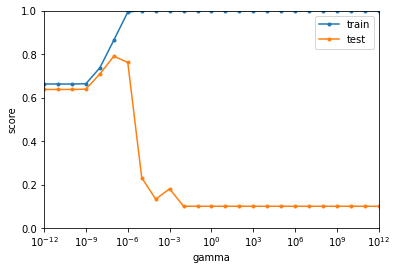

In [12]:
from sklearn.model_selection import train_test_split

# Implement. Do not change the name or signature of this function.
def plot_1():
    def evaluate_SVM_fixed_C(X, y, gamma):
        return evaluate_SVM(X, y, 1, gamma)
    
    Xs, _, ys, _ = train_test_split(X, y, stratify=y, train_size=0.01)
    gamma_space = np.logspace(-12, 12, num=25)
    plot_live(Xs, ys, evaluate_SVM_fixed_C, 'gamma', gamma_space)

plot_1()

### Question 1.2 (1p)
Interpret the graph. Answer the following questions with multiple choice:  
- 'A': Underfitting
- 'B': Overfitting
- 'C': Neither underfitting nor overfitting
- 'D': No answer

For the gamma value 1e-9, is the model over- or underfitting?

In [7]:
# Fill in the correct answer. Don't change the name of the variable
q_1_2_1 = 'A'

For the gamma value 1e3, is the model over- or underfitting?

In [8]:
# Fill in the correct answer. Don't change the name of the variable
q_1_2_2 = 'B'

### Question 1.3 (1p)
Implement a function `plot_1_3` that plots the graph similar as in question 1.1, but this time, fix `gamma` to the optimal value you observed in question 1.1, and vary `C` from 1e-12 to 1e12 (25 values on a log scale).

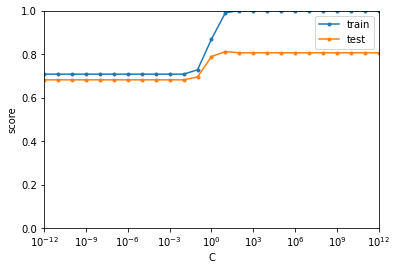

In [13]:
# Implement. Do not change the name or signature of this function.
def plot_1_3():
    def evaluate_SVM_fixed_gamma(X, y, C):
        return evaluate_SVM(X, y, C, 1e-7)
    
    Xs, _, ys, _ = train_test_split(X, y, stratify=y, train_size=0.01)
    C_space = np.logspace(-12, 12, num=25)
    plot_live(Xs, ys, evaluate_SVM_fixed_gamma, 'C', C_space)

plot_1_3()

### Question 1.4 (1p)
Interpret the graph. 

For the C value 1e6, is the model over- or underfitting?
- 'A': Strongly underfitting
- 'B': Strongly overfitting
- 'C': Neither underfitting nor overfitting
- 'D': No answer

In [10]:
# Fill in the correct answer. Don't change the name of the variable
q_1_4_1 = 'C'

Explain your observations as a string in `q_1_4_2`. What is the effect of using high C values on performance? How do you explain this? Use no more than 800 characters.

In [77]:
q_1_4_2 = """
Around C=10 we reach a perfect training score, but the test score drops slightly below the optimum. Using even higher C              values does not affect performance at all, because the margin around the decision boundary is already very small. As a               consequence, there are (almost) no support vectors.
          """
print("Answer is {} characters long".format(len(q_1_4_2.strip())))

Answer is 317 characters long


### Question 2.1 (2p)
Train a linear SVM with two different methods and compare them in terms of performance and scalability
- SVM with quadratic programming, as in `SVC`
- SVM with stochastic gradient descent

Think about which settings (loss functions, kernels, other settings) you need to use. Otherwise, you can leave hyperparameters at their defaults. 
Train both methods on 10 increasingly large stratified subsamples of the dataset, from 1% to 10%. Make sure that the larger samples contain all data from the smaller samples.

Implement a function `plot_2_1` that produces two plots. The first plot should show training time vs dataset size (or percentage). To get meaningful timing information, run both methods on the same machine with the same number of cores. You can use the standard 'time' package to measure runtime. The second plot should show the test set accuracy vs dataset size (or percentage). The test set consists of all the points not used for testing that model (hence 99% initially). Don't forget to add axis labels and legends.

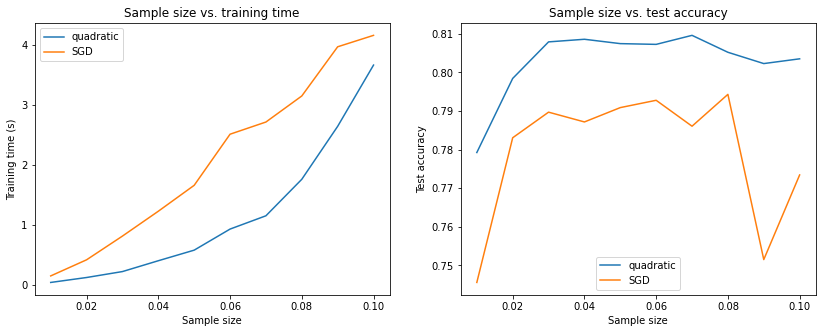

In [102]:
from time import time
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

# Implement. Do not change the name or signature of this function.
def plot_2_1():
    def train(train_size, train_size_prev, X_train, X_test, y_train, y_test):
        X_train_add, X_test, y_train_add, y_test = train_test_split(
            X_test, y_test, stratify=y_test,
            train_size=(train_size-train_size_prev)/(1-train_size_prev),
            random_state=42
        )
        X_train = pd.concat([X_train, X_train_add])
        y_train = pd.concat([y_train, y_train_add])

        svc = SVC(kernel='linear')
        svc_start = time()
        svc.fit(X_train, y_train)
        svc_end = time()

        sgd = SGDClassifier(loss='hinge', n_jobs=1)
        sgd_start = time()
        sgd.fit(X_train, y_train)
        sgd_end = time()

        return {
            'scores': {
                'SVC': svc.score(X_test, y_test),
                'SGD': sgd.score(X_test, y_test)
            },
            'times': {
                'SVC': svc_end - svc_start,
                'SGD': sgd_end - sgd_start
            }
        }

    X_train = pd.DataFrame()
    y_train = pd.Series()
    X_test = X
    y_test = y
    train_size_prev = 0

    def train_iter(train_size):
        return train(train_size, train_size_prev, X_train, X_test, y_train, y_test)

    domain = []
    results = []
    for train_size in np.linspace(0.01, 0.1, num=10):
        print(f'\r{train_size:.2f}', end='')
        domain.append(train_size)
        results.append(train_iter(train_size))

    # def plot_live(X, y, evaluator, param_name, param_range, scale='log', ylim=(0,1), ylabel='score', marker = '.'):
    plt.figure(figsize=(14,5))

    plt.subplot(121)
    plt.title('Sample size vs. training time')
    plt.xlabel('Sample size')
    plt.ylabel('Training time (s)')
    times = [result['times'] for result in results]
    plt.plot(domain, [time['SVC'] for time in times], label='quadratic')
    plt.plot(domain, [time['SGD'] for time in times], label='SGD')
    plt.legend()

    plt.subplot(122)
    plt.title('Sample size vs. test accuracy')
    plt.xlabel('Sample size')
    plt.ylabel('Test accuracy')
    scores = [result['scores'] for result in results]
    plt.plot(domain, [score['SVC'] for score in scores], label='quadratic')
    plt.plot(domain, [score['SGD'] for score in scores], label='SGD')
    plt.legend()
plot_2_1()

### Question 2.2 (1p)
Interpret the graphs. Which of the following is correct. Multiple correct answers are possible. You can run additional experiments if you are not sure. You can leave an optional short clarification in `q_2_2_comment`.
- 'A': The quadratic programming SVM is better at learning from small datasets, but is also a low slower than SGD
- 'B': The quadratic programming SVM is about equally good and trains equally fast as SGD
- 'C': The quadratic programming SVM is about equally good and trains faster than SGD
- 'D': The SGD SVM is equally good as the quadratic programming SVM given sufficent data, and faster
- 'E': The SGD SVM is better at learning from small datasets, and trains equally fast as the quadratic programming SVM
- 'F': The SGD SVM is worse at learning from small datasets, but given more data it will be equally good in the same amount of time
- 'G': The linear kernel performs much worse than the RBF kernel used in the previous questions

In [105]:
# Fill in the correct answer. Don't change the name of the variable. For multiple answers, use comma-separated values as shown.
q_2_2 = 'C,F'
q_2_2_comment = 'While the quadratic programming SVM trains faster than the SGD SVM for the given sample sizes, it looks like the training time for SGD is growing more slowly than for the quadratic SVM. Hence I would expect SGD to be faster for larger sample sizes.' # Optional. Only use when you feel that you need to clarify something.

### Question 3.1 (2p)
Inspect the SVM model to see whether it has learned the right thing.

First, relabel the data into a binary problem. Make class 1 "Trouser" the positive class and all other classes the negative class.
Next, train an SVM using C=1 and gamma=1e-7 on a 1% stratified subsample (as before).

Implement a function `plot_3_` that plots the 5 support vectors with the highest dual coefficients (as images), as well as the 5 support vectors with the lowest dual coefficients. You can use the plotting function `plot_examples` (see above) and add the values of the dual coefficients as labels. If there are more than 5 support vectors with the highest/lowest value you can choose any of them.

Explain your observations as a string in `answer_q_3`. What do the support vectors teach you about the model? How does it actually makes its predictions? Use no more than 800 characters.

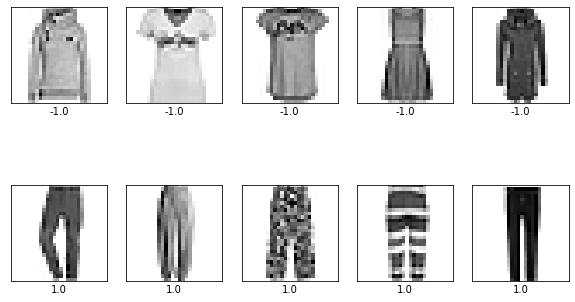

Answer is 645 characters long


In [178]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# Implement. Do not change the name or signature of this function.
def plot_3_1():
    # Subsample
    Xs, _, ys, _ = train_test_split(X, y, stratify=y, train_size=0.01, random_state=42)

    # Relabel the data
    ys_bin = []
    for cl in ys:
        if fmnist_classes[int(cl)] == 'Trouser':
            ys_bin.append(1)
        else:
            ys_bin.append(-1)

    # Train
    clf = SVC(C=1, gamma=1e-7).fit(Xs, ys_bin)

    # Plot
    sorted_coef = pd.Series(clf.dual_coef_[0]).sort_values()
    lowest = sorted_coef[:5]
    highest = sorted_coef[-5:]
    plot_examples(
        [clf.support_vectors_[i] for i in lowest.index] + [clf.support_vectors_[i] for i in highest.index],
        list(lowest) + list(highest)
    )
plot_3_1()

q_3_1 = """ 
        The support vectors are the samples that are closest to the decision boundary, according to the model. In this case, the support vectors with the highest dual coefficients are the images that are classified as trousers, but are very similar to non-trousers. The support vectors with lowest dual coefficients are the images that are classfied as non-trousers, but are very similar to trousers. We can see that the smallest dual coefficients are assigned to images of narrow and tall products. The model then makes predictions for new instances based on wether they are more similar to the positive support vectors or the negative support vectors.
        """
print("Answer is {} characters long".format(len(q_3_1.strip())))